C:\Users\louis\AppData\Local\Temp\ipykernel_10644\2664799556.py:167: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


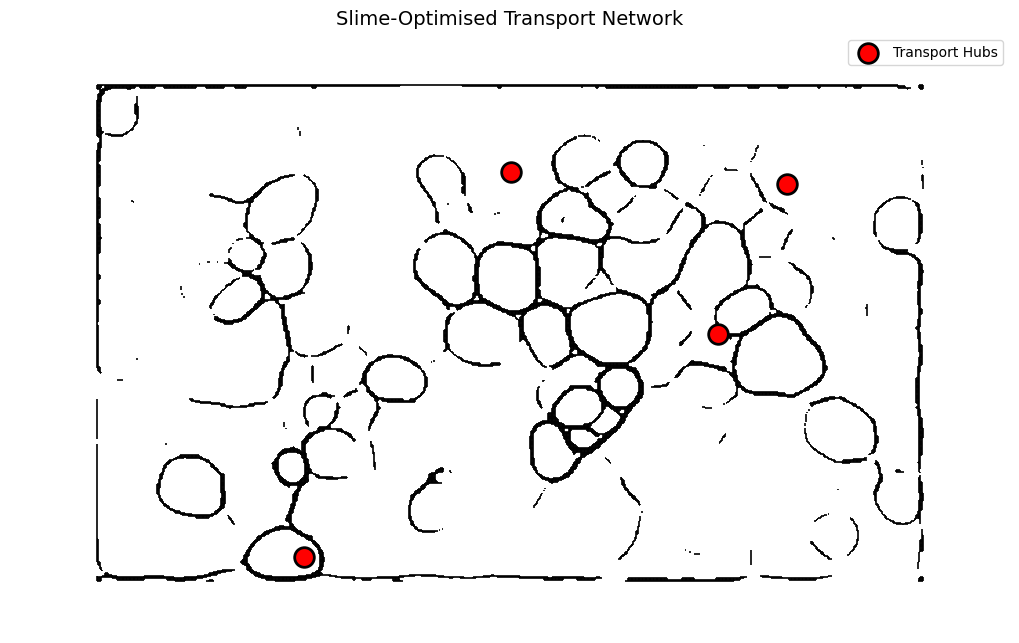

C:\Users\louis\AppData\Local\Temp\ipykernel_10644\2664799556.py:223: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


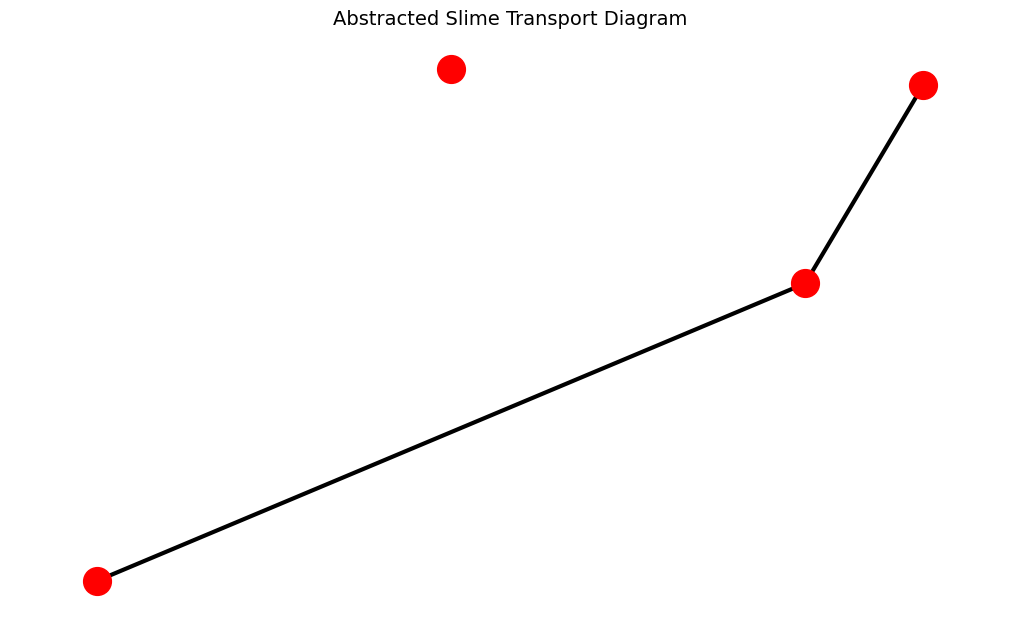

In [17]:
#TESTING SLIME SIMULATOR???
import imageio
import pygame
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import networkx as nx

# --- SETTINGS ---
WIDTH, HEIGHT = 600, 400
NUM_AGENTS = 2000
STEPS = 2000
SENSOR_DIST = 9
SENSOR_ANGLE = 0.5
STEP_SIZE = 1
DECAY = 0.01

pygame.init()
screen = pygame.display.set_mode((WIDTH, HEIGHT))
clock = pygame.time.Clock()

trail = np.zeros((WIDTH, HEIGHT))

food = [(150,380), (450,200), (500,80), (300,70)]

class Agent:
    def __init__(self):
        self.x = random.randint(0, WIDTH-1)
        self.y = random.randint(0, HEIGHT-1)
        self.angle = random.random() * 2 * math.pi

    def sense(self, offset):
        angle = self.angle + offset
        sx = int(self.x + math.cos(angle) * SENSOR_DIST)
        sy = int(self.y + math.sin(angle) * SENSOR_DIST)
        if 0 <= sx < WIDTH and 0 <= sy < HEIGHT:
            return trail[sx, sy]
        return 0

    def update(self):
        left = self.sense(-SENSOR_ANGLE)
        forward = self.sense(0)
        right = self.sense(SENSOR_ANGLE)

        if forward < left:
            self.angle -= 0.3
        elif forward < right:
            self.angle += 0.3

        self.x += math.cos(self.angle) * STEP_SIZE
        self.y += math.sin(self.angle) * STEP_SIZE

        self.x = max(0, min(WIDTH-1, self.x))
        self.y = max(0, min(HEIGHT-1, self.y))

        trail[int(self.x), int(self.y)] += 1


agents = [Agent() for _ in range(NUM_AGENTS)]

# --- RUN SIMULATION ---
video_writer = imageio.get_writer("slime_growth.mp4", fps=30)

for step in range(STEPS):

    for agent in agents:
        agent.update()

    # decay
    trail[:] *= (1 - DECAY)

    # food attractors
    for f in food:
        trail[f[0], f[1]] += 50

video_writer.close()
pygame.quit()

# ============================
# EXTRACT NETWORK FROM TRAIL
# ============================

threshold = np.percentile(trail, 90)
binary = trail > threshold

G = nx.Graph()

# Add nodes from strong trail pixels
for x in range(WIDTH):
    for y in range(HEIGHT):
        if binary[x,y]:
            G.add_node((x,y))

# Connect neighbors
for x,y in G.nodes():
    for dx,dy in [(-1,0),(1,0),(0,-1),(0,1)]:
        neighbor = (x+dx, y+dy)
        if neighbor in G.nodes():
            G.add_edge((x,y), neighbor)
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy.ndimage import gaussian_filter

# -------------------------------
# CLEAN TRAIL BEFORE EXTRACTION
# -------------------------------

# Smooth to remove pixel noise
smooth = gaussian_filter(trail, sigma=1)

# Stronger threshold → cleaner network
threshold = np.percentile(smooth, 93)
binary = smooth > threshold

G = nx.Graph()

# Add nodes
for x in range(WIDTH):
    for y in range(HEIGHT):
        if binary[x, y]:
            G.add_node((x, y))

# Connect neighbors
for x, y in list(G.nodes()):
    for dx, dy in [(-1,0),(1,0),(0,-1),(0,1)]:
        neighbor = (x+dx, y+dy)
        if neighbor in G:
            G.add_edge((x, y), neighbor)

# -------------------------------
# PLOT CLEAN NETWORK
# -------------------------------

plt.figure(figsize=(10,6))
pos = {node: node for node in G.nodes()}

# Draw paths thicker and darker
nx.draw(
    G,
    pos=pos,
    node_size=0,
    edge_color="black",
    width=1.2
)

# Draw food nodes clearly
food_x = [f[0] for f in food]
food_y = [f[1] for f in food]

plt.scatter(
    food_x,
    food_y,
    s=200,
    marker="o",
    facecolors="red",
    edgecolors="black",
    linewidths=2,
    zorder=5,
    label="Transport Hubs"
)

plt.gca().invert_yaxis()
plt.title("Slime-Optimised Transport Network", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()
# =====================================
# BUILD HUB-TO-HUB TRANSPORT GRAPH
# =====================================

import itertools
from scipy.spatial.distance import euclidean

# Create graph of hubs only
G_transport = nx.Graph()

# Add hubs as nodes
for i, hub in enumerate(food):
    G_transport.add_node(i, pos=hub)

# Measure connection strength using trail intensity along straight line
def corridor_strength(p1, p2, samples=100):
    xs = np.linspace(p1[0], p2[0], samples).astype(int)
    ys = np.linspace(p1[1], p2[1], samples).astype(int)
    return np.mean(trail[xs, ys])

# Compute strengths
connections = []
for (i, hub1), (j, hub2) in itertools.combinations(enumerate(food), 2):
    strength = corridor_strength(hub1, hub2)
    connections.append((i, j, strength))

# Keep only strongest corridors
strength_values = [c[2] for c in connections]
threshold_strength = np.percentile(strength_values, 70)

for i, j, strength in connections:
    if strength > threshold_strength:
        G_transport.add_edge(i, j, weight=strength)

# =====================================
# PLOT CLEAN TRANSPORT DIAGRAM
# =====================================

plt.figure(figsize=(10,6))

pos = nx.get_node_attributes(G_transport, 'pos')

nx.draw(
    G_transport,
    pos=pos,
    with_labels=False,
    node_size=400,
    node_color="red",
    edge_color="black",
    width=3
)

plt.gca().invert_yaxis()
plt.title("Abstracted Slime Transport Diagram", fontsize=14)
plt.tight_layout()
plt.show()


